In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from psyrun.store.npz import NpzStore
import seaborn as sns

In [3]:
sns.set('paper', 'ticks')

In [4]:
neuron_type_order = ['LIF', 'Direct']
backend_order = ['reference', 'optimized', 'ocl_cpu', 'ocl_gpu']

## Circular convolution network

In [5]:
df = pd.DataFrame(NpzStore().load('../data/time_cconv.npz')).query('neuron_type != "LIFRate"')

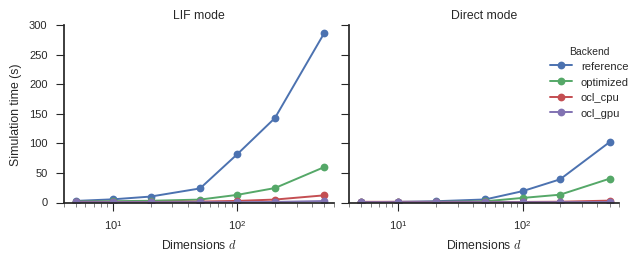

In [6]:
g = sns.FacetGrid(
    df.query('model == "circ_conv" and n_neurons == 500'),
    col='neuron_type', col_order=neuron_type_order,
    hue='backend', hue_order=backend_order,
    size=7. / 2.54)
def lineplot(x, y, unit, condition, data, **kwargs):
    del kwargs['label']
    data = data.reset_index()
    return sns.tsplot(
        time=x, value=y, unit=unit, condition=condition, data=data,
        marker='o', err_style='ci_bars',
        **kwargs)
    
g.map_dataframe(lineplot, 'dimensions', 't_sim', unit='trial', condition='backend')
g.map(plt.semilogx)
g.set(xlim=(4, 600))
g.set_titles("{col_name} mode")
g.set_axis_labels("Dimensions $d$", "Simulation time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(1, 0.65))
plt.tight_layout()
plt.savefig('../figures/cconv_sim.pdf')

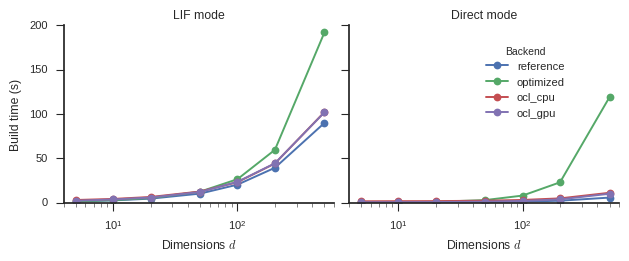

In [7]:
g = sns.FacetGrid(
    df.query('model == "circ_conv" and n_neurons == 500'),
    col='neuron_type', col_order=neuron_type_order,
    hue='backend', hue_order=backend_order,
    size=7. / 2.54)
def lineplot(x, y, unit, condition, data, **kwargs):
    del kwargs['label']
    data = data.reset_index()
    return sns.tsplot(
        time=x, value=y, unit=unit, condition=condition, data=data,
        marker='o', err_style='ci_bars',
        **kwargs)
    
g.map_dataframe(lineplot, 'dimensions', 't_build', unit='trial', condition='backend')
g.map(plt.semilogx)
g.set(xlim=(4, 600))
g.set_titles("{col_name} mode")
g.set_axis_labels("Dimensions $d$", "Build time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(.9, 0.65))
plt.tight_layout()
plt.savefig('../figures/cconv_build.pdf')

In [8]:
df.query('model == "circ_conv" and n_neurons == 500 and dimensions == 500').groupby(['neuron_type', 'backend']).mean()

dimensions  n_neurons     t_build  t_prefill  \
neuron_type backend                                                   
Direct      ocl_cpu         500.0        500   11.115046   0.070783   
            ocl_gpu         500.0        500   10.031017   0.018061   
            optimized       500.0        500  118.891740   0.370260   
            reference       500.0        500    5.695725   0.920071   
LIF         ocl_cpu         500.0        500  102.060608   0.163171   
            ocl_gpu         500.0        500  101.716882   0.035714   
            optimized       500.0        500  191.745526   0.590505   
            reference       500.0        500   89.792477   2.868889   

                            t_sim  trial  
neuron_type backend                       
Direct      ocl_cpu      3.426909      2  
            ocl_gpu      1.009194      2  
            optimized   40.443873      2  
            reference  102.230659      2  
LIF         ocl_cpu     12.374957      2  
            ocl_gpu      2.749192      2  
            optimized   60.221303      2  
            reference  287.155324      2

In [9]:
df.query('model == "circ_conv" and n_neurons == 500 and '
         '((neuron_type == "Direct" and backend == "reference") or '
         '(neuron_type == "LIF" and backend == "optimized"))').groupby(
    ['neuron_type', 'backend', 'dimensions']).mean()

n_neurons     t_build  t_prefill  \
neuron_type backend   dimensions                                     
Direct      reference 5.0               500    0.079342   0.007972   
                      10.0              500    0.154044   0.013885   
                      20.0              500    0.253310   0.023719   
                      50.0              500    0.536216   0.053731   
                      100.0             500    1.105962   0.117935   
                      200.0             500    2.180882   0.318136   
                      500.0             500    5.695725   0.920071   
LIF         optimized 5.0               500    1.506939   0.019120   
                      10.0              500    2.866616   0.024306   
                      20.0              500    5.188311   0.031416   
                      50.0              500   12.369143   0.050926   
                      100.0             500   26.438927   0.130210   
                      200.0             500   59.518533   0.241716   
                      500.0             500  191.745526   0.590505   

                                       t_sim  trial  
neuron_type backend   dimensions                     
Direct      reference 5.0           0.787370      2  
                      10.0          1.372118      2  
                      20.0          2.361873      2  
                      50.0          5.383416      2  
                      100.0        19.397876      2  
                      200.0        39.354125      2  
                      500.0       102.230659      2  
LIF         optimized 5.0           1.904999      2  
                      10.0          2.437120      2  
                      20.0          3.149534      2  
                      50.0          5.166817      2  
                      100.0        13.203028      2  
                      200.0        24.652749      2  
                      500.0        60.221303      2

In [10]:
def speedup(df, col, base='reference', cmp='optimized'):
    a = df.query('backend == {!r}'.format(base)).groupby('dimensions').mean()
    b = df.query('backend == {!r}'.format(cmp)).groupby('dimensions').mean()
    return a[col] / b[col]

In [11]:
# LIF simulation speedup
speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "LIF"'), 't_sim')

dimensions
5.0      1.523979
10.0     2.307038
20.0     3.257278
50.0     4.647635
100.0    6.224934
200.0    5.799494
500.0    4.768335
Name: t_sim, dtype: float64

In [12]:
# LIF build slow down
1. / speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "LIF"'), 't_build')

dimensions
5.0      1.180785
10.0     1.139217
20.0     1.151808
50.0     1.215857
100.0    1.303648
200.0    1.514490
500.0    2.135430
Name: t_build, dtype: float64

In [13]:
# Direct mode speed up
speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "Direct"'), 't_sim')

dimensions
5.0      1.055897
10.0     1.567412
20.0     1.800093
50.0     2.349037
100.0    2.433998
200.0    2.931096
500.0    2.527717
Name: t_sim, dtype: float64

In [14]:
# Direct mode slow down
1. / speedup(df.query('model == "circ_conv" and n_neurons == 500 and neuron_type == "Direct"'), 't_build')

dimensions
5.0       3.570735
10.0      3.329944
20.0      3.735435
50.0      5.377672
100.0     7.195294
200.0    10.500917
500.0    20.873855
Name: t_build, dtype: float64

## n-back task model

In [15]:
df = pd.DataFrame(NpzStore().load('../data/time_nback.npz')).query('neuron_type != "LIFRate"')
df['splits'] = 64 // df['sd']
df.columns

Index(['backend', 'model', 'neuron_type', 'sd', 't_build', 't_prefill',
       't_sim', 'trial', 'splits'],
      dtype='object')

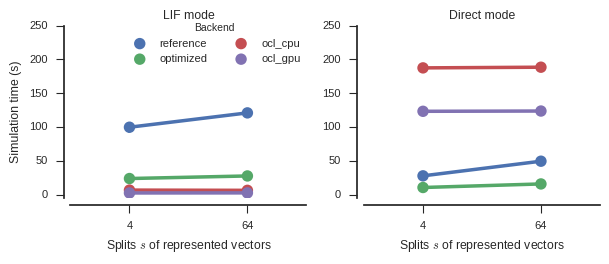

In [16]:
g = sns.FacetGrid(
    df.query('model == "nback"'),
    col='neuron_type', col_order=neuron_type_order,
    size=7. / 2.54, aspect=0.8)
    
g.map_dataframe(
    sns.pointplot, 'splits', 't_sim',
    hue='backend', hue_order=backend_order,
    palette='deep')
g.set(ylim=(-5, 250))
g.set_titles("{col_name} mode")
g.set_axis_labels("Splits $s$ of represented vectors", "Simulation time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(.5, 0.8), ncol=2, label_order=backend_order)
g.despine(offset=5)
plt.tight_layout()
plt.savefig('../figures/nback_sim.pdf')

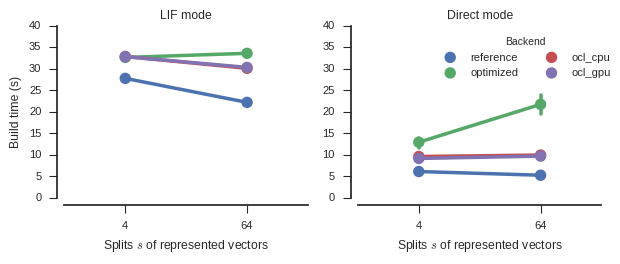

In [17]:
g = sns.FacetGrid(
    df.query('model == "nback"'),
    col='neuron_type', col_order=neuron_type_order,
    size=7. / 2.54, aspect=.8)
    
g.map_dataframe(
    sns.pointplot, 'splits', 't_build',
    hue='backend', hue_order=backend_order,
    palette='deep')
g.set_titles("{col_name} mode")
g.set_axis_labels("Splits $s$ of represented vectors", "Build time (s)")
g.add_legend(title="Backend", bbox_to_anchor=(1, 0.75), label_order=backend_order, ncol=2)
g.despine(offset=5)
plt.tight_layout()
plt.savefig('../figures/nback_build.pdf')

In [18]:
df.query('model == "nback"').groupby(['splits', 'neuron_type', 'backend']).mean()

sd    t_build  t_prefill       t_sim  trial
splits neuron_type backend                                               
4      Direct      ocl_cpu    16   9.626286   1.874741  187.521773      2
                   ocl_gpu    16   9.182127   1.235666  123.280125      2
                   optimized  16  12.947036   0.107094   10.538199      2
                   reference  16   6.142661   0.276526   27.779086      2
       LIF         ocl_cpu    16  32.845919   0.073359    6.687911      2
                   ocl_gpu    16  32.804521   0.025482    2.445145      2
                   optimized  16  32.624825   0.237170   23.804018      2
                   reference  16  27.764061   0.943278   99.719864      2
64     Direct      ocl_cpu     1   9.968122   1.931677  188.527207      2
                   ocl_gpu     1   9.723174   1.243817  123.672258      2
                   optimized   1  21.731246   0.160459   15.804178      2
                   reference   1   5.285847   0.500041   49.433721      2
       LIF         ocl_cpu     1  30.100063   0.064768    6.343064      2
                   ocl_gpu     1  30.314697   0.026918    2.566287      2
                   optimized   1  33.577299   0.275270   27.619660      2
                   reference   1  22.195637   1.210332  120.939004      2

## Spaun

In [19]:
df = pd.DataFrame(NpzStore().load('../data/time_spaun.npz')).query('neuron_type != "LIFRate"')

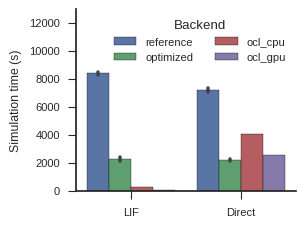

In [20]:
fig = plt.figure(figsize=(8. / 2.54, 6. / 2.54))
sns.barplot('neuron_type', 't_sim', hue='backend', data=df, hue_order=backend_order, order=neuron_type_order)
sns.despine()
plt.xlabel("")
plt.ylabel("Simulation time (s)")
plt.ylim(0, 1.3e4)
plt.legend(loc='best', ncol=2, title="Backend")
plt.tight_layout()
plt.savefig('../figures/spaun_sim.pdf')

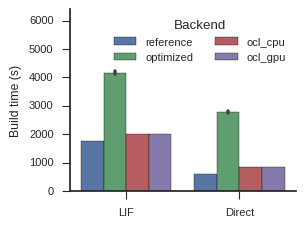

In [21]:
fig = plt.figure(figsize=(8. / 2.54, 6. / 2.54))
sns.barplot('neuron_type', 't_build', hue='backend', data=df, hue_order=backend_order, order=neuron_type_order)
sns.despine()
plt.xlabel("")
plt.ylabel("Build time (s)")
plt.ylim(0, 6.4e3)
plt.legend(loc='best', ncol=2, title="Backend")
plt.tight_layout()
plt.savefig('../figures/spaun_build.pdf')

In [22]:
df.query('model == "spaun"').groupby(['neuron_type', 'backend']).mean()

t_build  t_prefill        t_sim  trial
neuron_type backend                                              
Direct      ocl_cpu     830.179714  40.687515  4052.832311      2
            ocl_gpu     827.461748  26.162337  2593.473079      2
            optimized  2772.290770  21.671387  2238.318311      2
            reference   585.569352  72.153209  7242.370050      2
LIF         ocl_cpu    2009.777761   2.826381   285.762867      2
            ocl_gpu    2012.721889   0.635235    62.316642      2
            optimized  4163.392961  22.916912  2290.625870      2
            reference  1763.365434  84.063456  8417.261127      2